# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [1]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from api_ipython import SkaIPythonAPI as iapi
from parameter_definitions import *
from parameter_definitions import Constants as c
from implementation import Implementation as imp

%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes     = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg)
available_modes_all = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg, ImagingModes.All)
verbose_display = False

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Using default values, we can compare telescopes side-by-side

Telescope,SKA1_Low_rebaselined,SKA1_Mid_rebaselined,
Band,Low,Mid1,
Mode,Continuum,Continuum,
Baseline Dependent Time Avg.,False,False,
Max Baseline,80000,150000,m
Max # channels,65536,65536,
Optimal Number of Facets,1,2,
Optimal Snapshot Time,39.8,187.4,sec.
Visibility Buffer,25,51,PetaBytes
Working (cache) memory,13,200,TeraBytes
Image side length,3.34e+04,7.31e+04,pixels


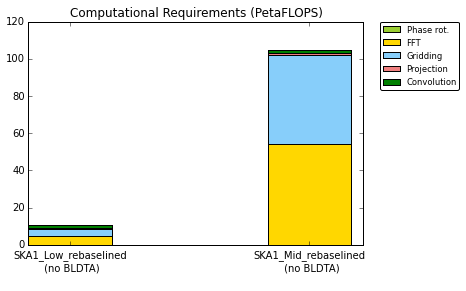

In [2]:
Tel1_BLDTA = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
Tel2_BLDTA = False
interact_manual(iapi.compare_telescopes_default, 
                Telescope_1=available_teles, Telescope_2=available_teles, Band_1=available_bands,
                Band_2=available_bands, Mode_1=available_modes_all, Mode_2=available_modes_all,
                Tel1_BLDTA=Tel1_BLDTA, Tel2_BLDTA=Tel2_BLDTA, verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [2]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact(iapi.evaluate_telescope_manual, max_baseline=(10000,200000), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         Telescope=available_teles, Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, 
         verbose=verbose_display);

Max Baseline,105000 m
Max # of channels,128000
Telescope,SKA1_Mid_rebaselined
Band,Mid1
Mode,Continuum
Tsnap,900.6 sec
Nfacet,5


Visibility Buffer,25.3 PetaBytes
Working (cache) memory,0.0614 TeraBytes
Image side length,20481 pixels
I/O Rate,161 TeraBytes/s
Total Compute Requirement,369 PetaFLOPS
-> Gridding,99.3 PetaFLOPS
-> FFT,3.75 PetaFLOPS
-> Projection,0.105 PetaFLOPS
-> Convolution,265 PetaFLOPS
-> Phase Rotation,0.316 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,105000 m
Max # of channels,256000
Telescope,SKA1_Mid_rebaselined
Band,Mid2
Mode,Continuum


Optimal Number of Facets,7
Optimal Snapshot Time,3.04e+03 sec.
Visibility Buffer,4.03 PetaBytes
Working (cache) memory,8.73 TeraBytes
Image side length,14629 pixels
I/O Rate,50.2 TeraBytes/s
Total Compute Requirement,13.5 PetaFLOPS
-> Gridding,0.867 PetaFLOPS
-> FFT,6.3 PetaFLOPS
-> Projection,0 PetaFLOPS
-> Convolution,6.19 PetaFLOPS


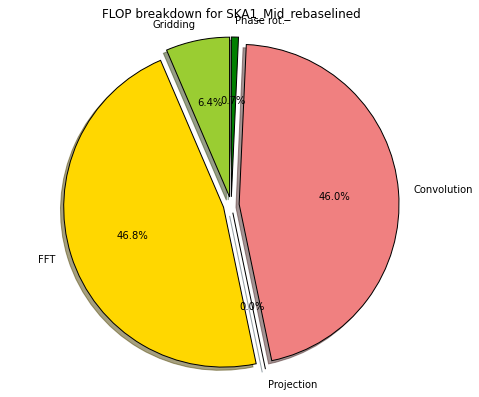

In [4]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10000,200000), Nf_max = (1,256000,1), Telescope=available_teles, 
         Band=available_bands, Mode=available_modes_all, BL_dep_time_av=BL_dep_time_av, verbose=verbose_display);

## illustrating 1D "parameter sweep" + visualization functionality.

Starting sweep of parameter Qkernel, evaluating expression Rflop over range (1.0, 10) in 9 steps (i.e. 10 data points)
> 0.0% done: Evaluating Rflop for Qkernel = 1
> 10.0% done: Evaluating Rflop for Qkernel = 2
> 20.0% done: Evaluating Rflop for Qkernel = 3
> 30.0% done: Evaluating Rflop for Qkernel = 4
> 40.0% done: Evaluating Rflop for Qkernel = 5
> 50.0% done: Evaluating Rflop for Qkernel = 6
> 60.0% done: Evaluating Rflop for Qkernel = 7
> 70.0% done: Evaluating Rflop for Qkernel = 8
> 80.0% done: Evaluating Rflop for Qkernel = 9
> 90.0% done: Evaluating Rflop for Qkernel = 10
done with parameter sweep!


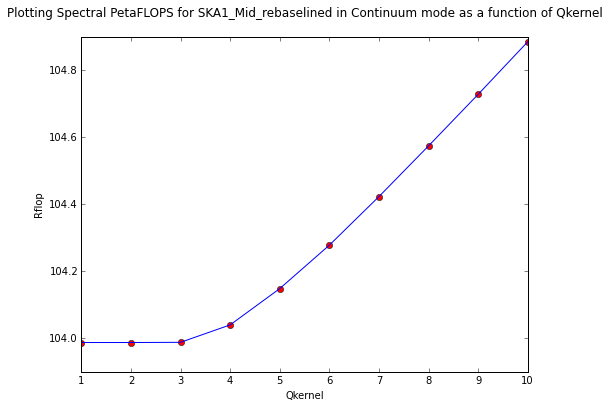

In [8]:
from IPython.display import display, HTML

expression = 'Rflop'
parameter = 'Qkernel'
param_val_min = 1.0
param_val_max = 10
number_steps = 9
telescope = Telescopes.SKA1_Mid
immode = ImagingModes.Continuum
band=Bands.Mid1

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=band, 
                                                   expression=expression, parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, verbose=False)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/c.peta, xlabel=parameter, ylabel=expression)

## illustrating 2D "parameter sweep" + visualization functionality.

Evaluating expression Rflop while
sweeping parameters Qkernel and amp_f_max over 2D domain [1, 10] x [1.01, 1.06] in 2 steps each,
for a total of 9 data evaluation points
> 0.0% done: Evaluating Rflop for (Qkernel, amp_f_max) = (1.0, 1.01)
> 11.1% done: Evaluating Rflop for (Qkernel, amp_f_max) = (1.0, 1.035)
> 22.2% done: Evaluating Rflop for (Qkernel, amp_f_max) = (1.0, 1.06)
> 33.3% done: Evaluating Rflop for (Qkernel, amp_f_max) = (5.5, 1.01)
> 44.4% done: Evaluating Rflop for (Qkernel, amp_f_max) = (5.5, 1.035)
> 55.6% done: Evaluating Rflop for (Qkernel, amp_f_max) = (5.5, 1.06)
> 66.7% done: Evaluating Rflop for (Qkernel, amp_f_max) = (10.0, 1.01)
> 77.8% done: Evaluating Rflop for (Qkernel, amp_f_max) = (10.0, 1.035)
> 88.9% done: Evaluating Rflop for (Qkernel, amp_f_max) = (10.0, 1.06)
done with parameter sweep!


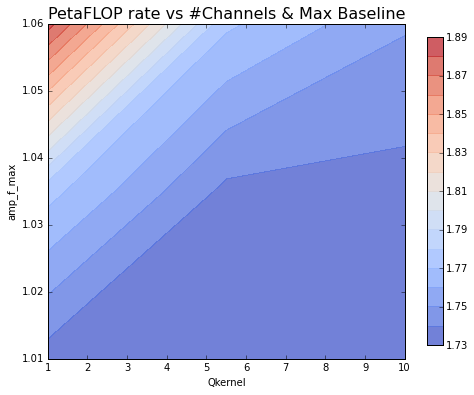

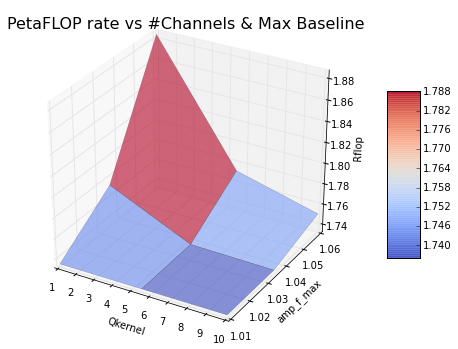

In [9]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Low
band = Bands.Low
immode = ImagingModes.Spectral
expression = 'Rflop'
parameters = ('Qkernel', 'amp_f_max')
parameter_ranges = ((1,10),(1.01,1.06))
number_steps = 2
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           verbose=verbose)


iapi.plot_2D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], contours=np.array((0.5, 1.0)))
iapi.plot_3D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], zlabel=expression, contours=np.array((0.5, 1.0)))